# CLASSIFYING THE AGE GROUP OF ABALONE FROM PHYSICAL MEASUREMENTS

Data Source: UCI Machine Learning Repository

## Objective of the Analysis
Abalone is considered the most expensive seafood in the world. The price of abalone is highly correlated with its age. Researchers use the number of rings +/- 1.5 years to estimate the age of abalone as the ring is formed once a year. Researchers must cut the shell, stain it, examine the shell sample through a microscope and then count the number of rings. This process of determining the age of abalone can be very cumbersome and costly. Our goal in this study is to classify the age group of abalone based on physical measurements, which can be easily obtained at a lower cost. 

The following multivariate techniques will be applied in our analysis: 
Dimensionality Reduction: Principal Component Analysis

Classification: k Nearest Neighbor, Linear Discriminant Analysis, Quadratic Discriminant Analysis


In [1]:
proc import 
datafile = '~/Abalone.txt'
out = Abalone
dbms = dlm
replace;
delimiter = ',';

SAS Connection established. Subprocess id is 3000



In [2]:
proc contents data=abalone;
run;

The Abalone dataset [1] obtained from the UCI Machine Learning Repository, contains 4,177 observations, with 9 different variables. For the purpose of this study, we will exclude the SEX variable and only use the physical numerical measures as the predictors variables for our statistical model. All variables used in this analysis are measured on a continuous scale.



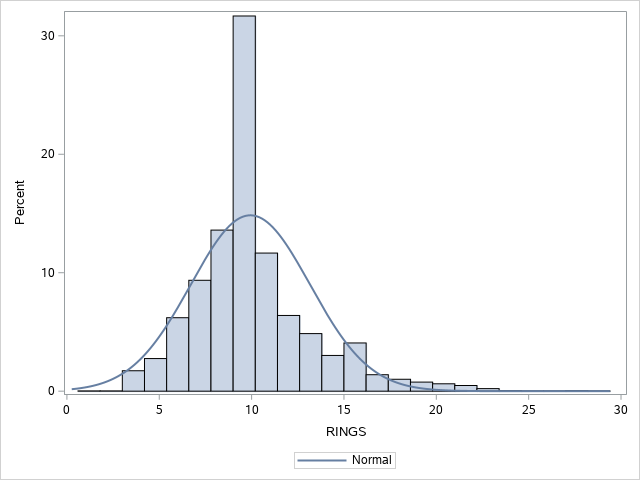

In [3]:
proc sgplot data=abalone;
  histogram rings;
  density rings;
run;

The number of rings varies from 1 to 29. We decided to partition this variable into three groups using the following rules: 

RINGS < 9 => ageRings: 1

9 <= RINGS <= 10 => ageRings: 2

RINGS > 10 => ageRings: 3

After the partition process, each age group contains approximately 33% of the dataset.

In [7]:
/* Drop variable 'SEX' */
data Abalone2;
set Abalone;
keep LENGTH DIAMETER HEIGHT WHOLEWEIGHT SHUCKEDWEIGHT VISCERAWEIGHT SHELLWEIGHT RINGS;
RUN;

/* Define the age group */
data Abalone3;
set Abalone2;
if RINGS <9 then ageRINGS = 1;
if RINGS <= 10 and RINGS >= 9 then ageRINGS = 2;
if RINGS > 10 then ageRINGS = 3;

/* Distribution of ageRings */
PROC FREQ data=abalone3;
tables agerings;
run;

ageRINGS,Frequency,Percent,CumulativeFrequency,CumulativePercent
1,1407,33.68,1407,33.68
2,1323,31.67,2730,65.36
3,1447,34.64,4177,100.00


# Data Description
## Univariate Analysis and Bivariate Analysis

In [9]:
proc corr data= abalone2 plots=matrix(histogram);
var LENGTH DIAMETER HEIGHT WHOLEWEIGHT SHUCKEDWEIGHT VISCERAWEIGHT SHELLWEIGHT RINGS;
run;

The minimum value of RINGS is 1 whereas the maximum value is 29, indicating that some abalones are very young and some are very old. Thus it is reasonable to classify the RINGS variable into three age groups. Minimum value of HEIGHT is 0, which does not make sense. We noticed that there are only two observations with such value. This could be a typo that happened during the data entry process. 


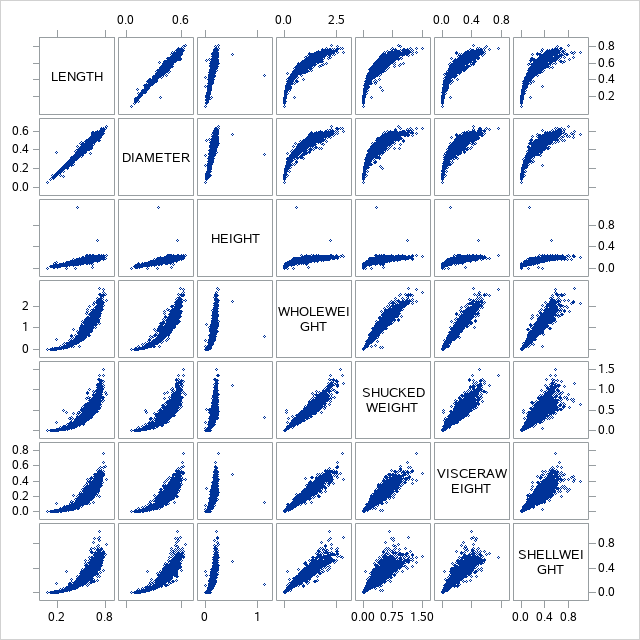

In [13]:
proc sgscatter data=abalone3;
  matrix LENGTH DIAMETER HEIGHT WHOLEWEIGHT SHUCKEDWEIGHT VISCERAWEIGHT SHELLWEIGHT;
run;

Based on the Correlation matrix and the Scatterplot, we noticed that Rings variable has the highest correlation with Shell Weight (0.62757), followed by Diameter (0.57466), Height (0.55747) and Length (0.55672). All variables are highly correlated with each other with the exception of Rings. For all variables except Rings, Height is least correlated with other variables. In this study, we will use Principal Component Analysis as a remedial solution for multicollinearity and high dimensionality. 

# DIMENSIONALITY REDUCTION - PRINCIPAL COMPONENT ANALYSIS (PCA)
## S matrix vs R matrix

Principal Component Analysis (PCA) is a dimensionality reduction technique that is often used for datasets with a large number of variables as it helps the user distinguish between the independent variables that are the most important for the prediction versus the variables that are not so important. This technique is beneficial to multivariate analysis because it removes the need to understand the relationship between each variable, reduces the noise within your data and also reduces the risk of overfitting your model.



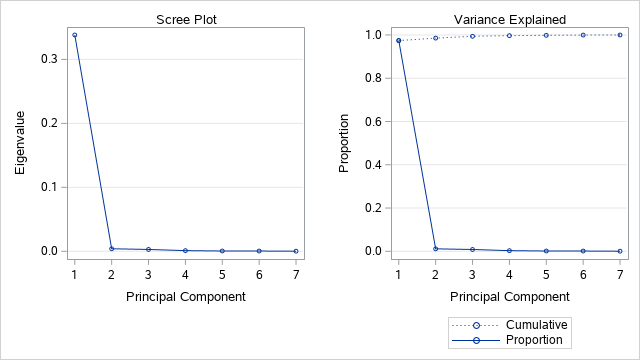

In [12]:
proc princomp data = abalone3 cov out=result;
var LENGTH DIAMETER HEIGHT WHOLEWEIGHT SHUCKEDWEIGHT VISCERAWEIGHT SHELLWEIGHT;
run;

PCA will be performed using the 7 independent variables: LENGTH, DIAMETER, HEIGHT, WHOLE, WEIGHT, SHUCKEDWEIGHT, VISCERA, WEIGHT, SHELL, and WEIGHT. Total variation is the trace of the covariance matrix, this is the sum of all variances of the individual variables. The total variation of this dataset is .3471

The variances of the variables are not consistent - namely WHOLEWEIGHT has a variance of .24 (approximately 70% of the total variation), while the remaining 6 variables all have small variances under .05. Similarly, the first PC of S accounts for approximately 97% of the variance, whereas it would take 3 PCs of R to account for the same variance (see below). With the large variance of WHOLEWEIGHT (.24), it is expected that WHOLEWEIGHT will account for most of the variance noted in the first PC. This pattern is also reflected in the eigenvector of the PC with the coefficient of WHOLEWEIGHT (.843) dominating the coefficients of the other variables. 

Given this information, we should extract the components from the R matrix rather than the S matrix. The correlation matrix of the eigenvalues  shows that the first two eigenvalues account for 95% of the variance, giving us a 5% lost in variance which satisfies our requirement.



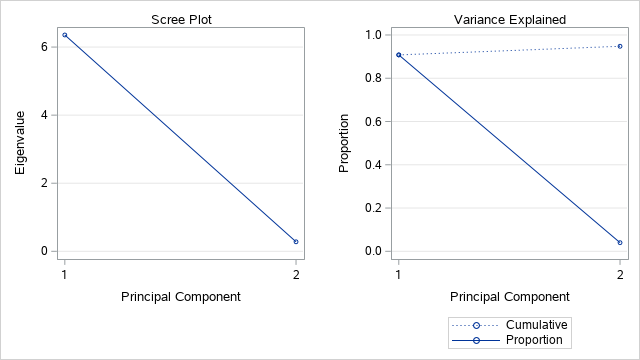

In [14]:
/* Apply PCA using R matrix, create a new dataset with 2 PCs*/
proc princomp data = abalone3 out=NewData n=2;
var LENGTH DIAMETER HEIGHT WHOLEWEIGHT SHUCKEDWEIGHT VISCERAWEIGHT SHELLWEIGHT;
run;

The absolute value of the coefficients within the principal component shows the contribution of the corresponding variable. From the equation, you can see that the coefficients of the first PC are all positively correlated, indicating z1 will increase if all 7 variables increase. Within the second PC, we have a mixture of positive and negative coefficients, HEIGHT dominates this PC and thus makes this PC variable-specific. 

## Outliers Detection and Visualization 
Now that we have lower dataset representation, we can easily visualize the distribution of predictor variables. We can see that there is a presence of outliers in this dataset. 



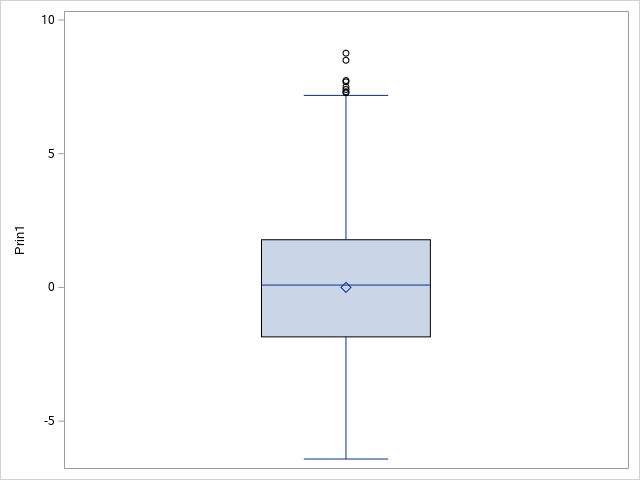
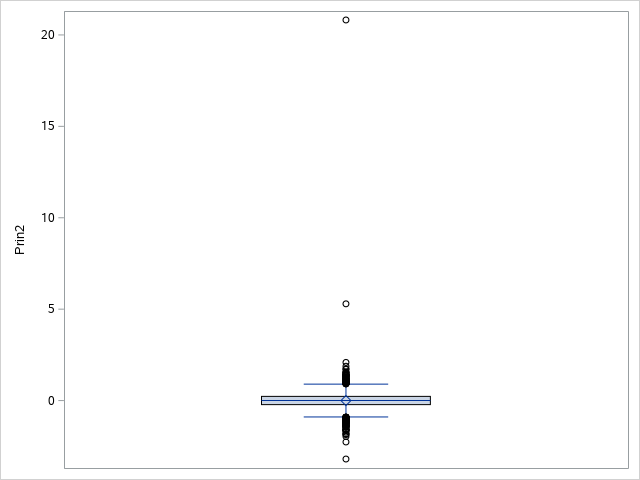

In [15]:
/* Box plot */
proc sgplot data=NewData;
  vbox prin1;
run;
proc sgplot data=NewData;
  vbox prin2;
run;


We apply Tukey’s rule to find outliers based on the quartiles of the data: the first quartile Q1 is the value >= ¼ of the data, the second quartile Q2 or the median is the value >= ½ of the data, and the third quartile Q3 is the value >= ¾ of the data. The interquartile range (IQR) can be defined as the difference between Q3 and Q1. According to Tukey’s rule, the outliers are values that are more than 1.5 times the IQR from the quartiles - either below Q1 - 1.5IQR or above Q3+1.5IQR. Below are the boxplots for PC1 and PC2 after the outliers were removed.  


In [16]:
/* Outliers detection */
proc univariate data = NewData;
var prin1 prin2;
output out=boxStats p25=q1_1 q1_2 p75=q3_1 q3_2  qrange = iqr1 iqr2;
run; 
data _null_;
set boxStats;
call symput ('Q1_1',q1_1);
call symput ('Q1_2',q1_2);
call symput ('Q3_1',q3_1);
call symput ('Q3_2',q3_2);
call symput ('iqr1', iqr1);
call symput ('iqr2', iqr2);
run; 
data trimmed;
set NewData;
    if (prin1 ge &q1_1 - 1.5 * &iqr1) and (prin1 le &q3_1 + 1.5 * &iqr1); 
    if (prin2 ge &q1_2 - 1.5 * &iqr2) and (prin2 le &q3_1 + 1.5 * &iqr2); 
run; 



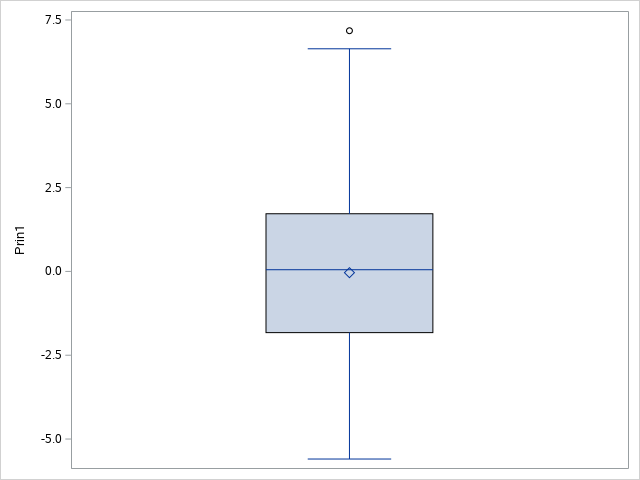
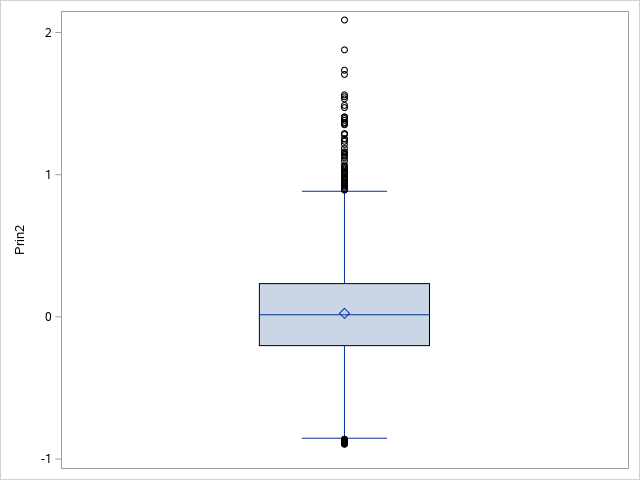

In [17]:
/* Plot the trimmed dataset */
proc sgplot data=trimmed;
  vbox prin1;
run;
proc sgplot data=trimmed;
  vbox prin2;
run;
proc contents data=trimmed;
run;

The dataset now has 4068 observations, meaning 109 outliers were removed.


In [21]:
/* PROC PLOT data=trimmed;
plot prin2*prin1=ageRINGS;
run; */

We then plotted the first two PCs against each other and noticed that the age group of abalone actually related with the PC1. Group 1 (young abalone) tends to fall around the far left region of the plot whereas Group 3 (old abalone) falls around the far right region. The middle region is the mix of Group 2 and Group 3, which indicates that it might be hard to distinguish between Group 2 and Group 3. 

# CLASSIFICATION - k NEAREST NEIGHBORS (KNN)

Classification is a statistical method to identify which group membership the sampling unit belongs to. KNN is a nonparametric classification procedure, which does not make any assumption on the underlying data distribution. KNN, however, does make an assumption that similar points share similar labels. KNN is a very simple yet powerful model because in practice most of the data does not obey the typical normality assumption. However, the procedure requires equal covariances for every group assumptions. The major drawbacks of KNN are its low efficiency because we need to calculate the distance to all other points and its dependency on the selection of an appropriate value for k [2]. As mentioned above, KNN assumes that similar points share similar class labels. In higher dimensional spaces, points that are drawn from a probability distribution are not very close together. Thus we have used PCA to reduce the dimensionality of the dataset.


We will use error rate to evaluate the ability of a classification procedure to predict group membership. The procedure assumes that the sampling unit being classified actually belongs to the considered population. If the sampling unit is wrongly classified, then it is considered an error. The Apparent Error Rate usually underestimates the actual error because the dataset used to compute the classification functions is also used to evaluate them. Thus we use the error rate from the holdout method to assess how well our statistical procedure will generalize to an independent dataset. For KNN classifiers, the observation being classified is excluded from the k nearest neighbors of that observation. We noted that KNN relies on distance metric. The better that metric reflects group label similarity, the better the classified will be. So we will try different distance metrics and pick the one that produces the lowest error rate. 

## KNN - default setting using pooled covariance matrix

In [22]:
/* Apply KNN  - METRIC=FULL Default*/

proc discrim data=trimmed method=npar k=100 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar k=200 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar k=300 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar k=400 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar k=500 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

Although we started off with k = 100, we understood that many other values could possibly be used for this classifier. We noticed that the error rate decreased to 0.3811 and 0.3803 as we increased the number of  from 100 to 200 and 300 but slightly increased to 0.3908 and 0.3897 as k increased to 400 and 500.  The cross-validation error rate indicates that there should be a balance between  and the error rate. The higher  does not necessarily improve the model. The 200-nearest neighbor classifier is the best performing model with the lowest error rate of 0.3811.  

## KNN - IDENTITY metric using Euclidean distance

In [23]:
/* Apply KNN  - METRIC=IDENTITY*/
proc discrim data=trimmed method=npar metric=identity k=100 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=identity k=200 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=identity k=300 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=identity k=400 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=identity k=500 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

The 300-nearest neighbor classifier is the best performing model and yields the lowest error rate of 0.3892.

## KNN - DIAGONAL metric using the diagonal matrix of the pooled covariance matrix 


In [24]:
proc discrim data=trimmed method=npar metric=diagonal pool=yes k=100 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=diagonal pool=yes k=200 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run; 

proc discrim data=trimmed method=npar metric=diagonal pool=yes k=300 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=diagonal pool=yes k=400 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

proc discrim data=trimmed method=npar metric=diagonal pool=yes k=500 crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

The 200-nearest neighbor classifier is the best performing model and yields the lowest error rate of 0.3813.

# CLASSIFICATION - LINEAR DISCRIMINANT ANALYSIS AND QUADRATIC DISCRIMINANT ANALYSIS

Linear Discriminant Analysis (LDA) assumes equal covariance for every group. Quadratic Discriminant Analysis (QDA), on the other hand, does not assume the equal covariances for every group. Decision rule for LDA is to classify the sampling unit into the largest square distance whereas decision rule for QDA is to classify the sampling unit into a group with the smallest square distance.

In [27]:
proc discrim data=trimmed pool=no crossvalidate;
class ageRINGS;
var Prin1 Prin2;
run;

QDA model yields a lower error rate of 0.3968 using the hold out method. 

Among 17 models, the 200-nearest neighbor classifier using pooled covariance matrix to calculate the squared distance is the best performing model and yields the lowest error rate of 0.3811. We noticed all 17 models had a hard time distinguishing between Group 2 and Group 3, meaning observations belong to Group 2 were misclassified to Group 3 and vice versa. This is in line with our observation that it will be hard to separate Group 2 and Group 3.  

# Conclusions

This project studied classification through supervised learning algorithms by applying k-nearest neighbors to predict the age group of abalones. We used PCA to transform the dataset into lower dimension, remove the outliers and understand the distribution of the observations. We ran KNN models using three different distance metrics with  ranging from 100 to 500, LDA and QDA. Error rate from the holdout method was used to evaluate different models. We achieved the lowest error with the 200-nearest neighbor model using the pooled covariance matrix. 

[1] Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) “The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (H.rubra) from the North Coast and Islands of Bass Strait”, Sea Fisheries Division, Technical
Report No. 48 .

[2] G. Guo, H. Wang, D. Bell, Y. Bi, K. Greer, R. Meersman, Z. Tari, D. C. Schmidt, "KNN model-based approach in classification" in On the Move to Meaningful Internet Systems 2003: CoopIS DOA and ODBASE, Berlin, Germany:Springer, vol. 2888, pp. 986-996, 2003.
